In [5]:
from __future__ import division
import numpy as np
import scipy as sc
from itertools import product
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import PIL
from numpy import log10
import random
from math import factorial
from scipy.stats import linregress, gaussian_kde
from scipy import stats
from scipy.spatial import distance
import warnings
import pandas as pd
import re
import os
import math
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm
from scipy.optimize import linear_sum_assignment
import colorsys
from collections import Counter
import scipy.optimize as opt
import scipy.special as sp
import ot
import timeit

warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

pd.set_option('display.max_columns', None)


In [6]:
def beta_median(alpha, beta):
    """Compute the median of the Beta(alpha, beta) distribution numerically."""
    return opt.brentq(lambda x: stats.beta.cdf(x, alpha, beta) - 0.5, 0, 1)

def beta_gmean(alpha, beta):
    """Compute the geometric mean of the Beta(alpha, beta) distribution."""
    return np.exp(sp.digamma(alpha) - sp.digamma(alpha + beta))

def beta_hmean(alpha, beta):
    """Compute the harmonic mean of the Beta(alpha, beta) distribution."""
    if alpha <= 1:
        raise ValueError("Harmonic mean is undefined for alpha ≤ 1.")
    return (alpha - 1) / (alpha + beta - 1)


In [7]:

def create_mode_with_ties(data):
    # Count the frequencies of each element
    counter = Counter(data)
    
    # Find the most common value(s) and their count
    most_common_value, most_common_count = counter.most_common(1)[0]
    
    # If there's a tie (i.e., multiple elements with the same frequency), pick one
    return data + [most_common_value] * (most_common_count - 1)

def custom_mode(data):
    # Count the frequency of each element in the data
    counter = Counter(data)
    
    # Find the maximum frequency
    max_count = max(counter.values())
    
    # Get the first element that has the maximum frequency
    for value, count in counter.items():
        if count == max_count:
            return value

#          

# Beta Distribution

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from scipy import stats

def rainbow_colors(n):
    return [tuple(int(255 * c) for c in colorsys.hsv_to_rgb(i / n, 1, 1)) for i in range(n)]

# Create 3x3 subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 3.8))

beta_ls = [0.25, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]
alpha_ls = np.linspace(0.25, 10.0, 80).tolist()
colors = rainbow_colors(len(beta_ls))

# Titles for each plot
plot_titles = [r"Shift via Mean", r"Shift via Median", r"Shift via G-mean"]

# Create insets *before* the loop so they persist across iterations
insets = [inset_axes(ax, width="40%", height="40%", loc="upper left", 
                     bbox_to_anchor=(0.25, 0.0, 1, 1), 
                     bbox_transform=ax.transAxes) for ax in axes]


# Iterate over beta values
for beta, color in zip(beta_ls, colors):
    
    mean_ls = []
    median_ls = []
    gmean_ls = []
    skew_ls = []
    
    S_from_mean = []
    S_from_median = []
    S_from_gmean = []
    
    # Compute statistics for each alpha
    for alpha in alpha_ls:
        mean, var, skew, _ = stats.beta.stats(alpha, beta, moments='mvsk')
        mean_ls.append(mean)
        
        median = beta_median(alpha, beta)
        median_ls.append(median)
        
        gmean = beta_gmean(alpha, beta)
        gmean_ls.append(gmean)
        
        skew_ls.append(skew)
        
        # Compute shift measure based on mean
        S_from_mean.append((1 - mean) / (1 - 0))
        
        # Compute shift measure based on median
        S_from_median.append((1 - median) / (1 - 0))
        
        # Compute shift measure based on g-mean
        S_from_gmean.append((1 - gmean) / (1 - 0))

    # Plot each relationship in the main plots
    axes[0].plot(S_from_mean, skew_ls,  label=rf"$\beta = {beta}$", color=np.array(color) / 255)
    axes[1].plot(S_from_median, skew_ls,  color=np.array(color) / 255)
    #axes[2].plot(S_from_gmean, skew_ls, color=np.array(color) / 255)

    # Plot in the corresponding insets
    insets[0].axvline(x=0.5, ymin=1, ymax=-1, linewidth=1, color='0.5', ls='--')
    insets[0].axhline(y=0, xmin=0, xmax=1, linewidth=1, color='0.5', ls='--')
    insets[0].plot(S_from_mean, np.arctan(skew_ls)*(2/np.pi), color=np.array(color) / 255)
    
    insets[1].axvline(x=0.5, ymin=1, ymax=-1, linewidth=1, color='0.5', ls='--')
    insets[1].axhline(y=0, xmin=0, xmax=1, linewidth=1, color='0.5', ls='--')
    insets[1].plot(S_from_median, np.arctan(skew_ls)*(2/np.pi), color=np.array(color) / 255)
    #insets[2].plot(S_from_gmean, np.arctan(skew_ls)*(2/np.pi), color=np.array(color) / 255)

# Style insets
for i, inset in enumerate(insets):
    inset.set_xticks([0, 0.5, 1])
    inset.set_yticks([-1, 0, 1])
    
    inset.set_ylabel("arctan(" + r"$\gamma$" + ")" + r"$\cdot\frac{2}{\pi}$", fontsize=14)
    
    if i == 0:
        inset.set_xlabel(r"$S_{\mu}$")
    
    elif i == 1:
        inset.set_xlabel(r"$S_{MD}$")
    
    elif i == 2:
        inset.set_xlabel(r"$S_{GM}$")
    
# Set labels and titles
for i, ax in enumerate(axes):
    ax.set_xlabel([r"Shift, $S_{\mu}$", r"Shift, $S_{MD}$", r"Shift, $S_{GM}$"][i], fontsize=17)
    ax.set_ylabel(r"Skewness, $\gamma$", fontsize=18)
    ax.tick_params(axis='both', which='both', direction='in', length=6, labelsize=12)
    ax.grid(False)
    ax.set_ylim(-3.5, 5.8)

    
# Add labels in the lower right corners
axes[0].text(0.92, 0.08, 'A', transform=axes[0].transAxes, ha='center', va='center', fontsize=18, fontweight='bold')
axes[1].text(0.92, 0.08, 'B', transform=axes[1].transAxes, ha='center', va='center', fontsize=18, fontweight='bold')
#axes[2].text(0.92, 0.08, 'C', transform=axes[2].transAxes, ha='center', va='center', fontsize=18, fontweight='bold')

fig.legend(bbox_to_anchor=(0.115, 0.75, 0.795, .5), loc=10, ncol=4, mode="expand", prop={'size':12})
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.0, wspace=0.35)

plt.savefig('Final_Figs/manuscript/Fig1.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig1.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.close()



In [9]:
def get_S_from_bins(f, min_, max_):
    
    T = 0
    i_ls = list(range(min_, max_ + 1))
    for i, ival in enumerate(i_ls):
        T += ival * f[i]
        
    T = T/sum(f)
    S = (max_ - T)/(max_ - min_)
    return S


f1 = [1, 2, 1]
f2 = [0, 0, 1, 2, 1, 0, 0]
f3 = [0, 0, 1/4, 2/4, 1/4, 0, 0]
f4 = [1, 1, 2, 3, 5, 3, 2, 1, 1]
f5 = [5, 3, 2, 1, 1, 1, 2, 3, 5]

print((len(f1) - ((len(f1)+1)/2))/(len(f1) - 1))
print((len(f2) - ((len(f2)+1)/2))/(len(f2) - 1))
print((len(f3) - ((len(f3)+1)/2))/(len(f3) - 1))
print((len(f4) - ((len(f4)+1)/2))/(len(f4) - 1))
print((len(f5) - ((len(f5)+1)/2))/(len(f5) - 1), '\n')

offset = -1
min_ = 1 + offset
max_ = len(f1) + offset
S1 = get_S_from_bins(f1, min_, max_)
print('S1 =',S1, '| min =', min_, 'max =', max_)

offset = -1
min_ = 1 + offset
max_ = len(f2) + offset
S2 = get_S_from_bins(f2, min_, max_)
print('S2 =',S2, '| min =', min_, 'max =', max_)


offset = 0
min_ = 1 + offset
max_ = len(f3) + offset
S3 = get_S_from_bins(f3, min_, max_)
print('S3 =',S3, '| min =', min_, 'max =', max_)

offset = 9
min_ = 1 + offset
max_ = len(f4) + offset
S4 = get_S_from_bins(f4, min_, max_)
print('S4 =',S4, '| min =', min_, 'max =', max_)

offset = -19
min_ = 1 + offset
max_ = len(f5) + offset
S5 = get_S_from_bins(f5, min_, max_)
print('S5 =',S5, '| min =', min_, 'max =', max_)


0.5
0.5
0.5
0.5
0.5 

S1 = 0.5 | min = 0 max = 2
S2 = 0.5 | min = 0 max = 6
S3 = 0.5 | min = 1 max = 7
S4 = 0.5 | min = 10 max = 18
S5 = 0.5 | min = -18 max = -10


In [10]:
f = [5, 10, 5, 4, 3, 2, 1]
X = []
for i, fi in enumerate(f):
    X.extend([i+1]*fi)

#print(len(X))
#print(sum(f))

max_ = max(X)
min_ = min(X)

mu = np.mean(X)
md = np.median(X)
S_mu = (max_ - np.mean(X))/(max_ - min_)
S_md = (max_ - np.median(X))/(max_ - min_)

print('Xmax =', max_)
print('Xmin =', min_, '\n')

print('S_mu =', S_mu, '| mu =', mu)
print('S_md =', S_md, '| MD =', md)
print('ΔS =', S_mu - S_md, '\n')

print('mu/md =', mu/md)
print('md/mu =', md/mu)
print('mu - md =', mu - md)
print('md - mu =', md - mu)

Xmax = 7
Xmin = 1 

S_mu = 0.6666666666666666 | mu = 3.0
S_md = 0.75 | MD = 2.5
ΔS = -0.08333333333333337 

mu/md = 1.2
md/mu = 0.8333333333333334
mu - md = 0.5
md - mu = -0.5


In [11]:
import numpy as np

def skewness_binned_simple(bin_centers, f):
    f = np.array(f)
    N = np.sum(f)
    
    mean = np.sum(bin_centers * f) / N
    
    # Compute the standard deviation (weighted by frequencies)
    variance = np.sum(f * (bin_centers - mean)**2) / N
    std_dev = np.sqrt(variance)
    
    # Compute the skewness (weighted by frequencies)
    skew = np.sum(f * (bin_centers - mean)**3) / (N * std_dev**3)
    
    return skew



fs = [[0, 0, 0, 0, 1, 2, 1],
      [0, 0, 1, 2, 1, 0, 0],
      [1, 2, 1, 0, 0, 0, 0],
     ]

for f in fs:
    bin_centers = np.array(list(range(len(f))))
    skew = skewness_binned_simple(bin_centers, f)
    print("Skewness =", skew)
    
    X = []
    for i, fi in enumerate(f):
        X.extend([i+1]*(fi)) # here's where I lose the 0's

    # How do I solve this dilemma?
    # S_mu and S_md need to account for the fact the 0's matter
    # clearly the distributions are moving (shifting) across x-axis
    
    X = np.array(X)
    max_ = max(X)
    min_ = min(X)

    mu = np.mean(X)
    md = np.median(X)
    S_mu = (max_ - np.mean(X))/(max_ - min_)
    S_md = (max_ - np.median(X))/(max_ - min_)

    print("S_mu =", S_mu)
    print("S_md =", S_md)
    


Skewness = 0.0
S_mu = 0.5
S_md = 0.5
Skewness = 0.0
S_mu = 0.5
S_md = 0.5
Skewness = 0.0
S_mu = 0.5
S_md = 0.5


In [12]:
import numpy as np

def skewness_binned_simple(bin_centers, f):
    f = np.array(f)
    N = np.sum(f)
    
    mean = np.sum(bin_centers * f) / N
    
    # Compute the standard deviation (weighted by frequencies)
    variance = np.sum(f * (bin_centers - mean)**2) / N
    std_dev = np.sqrt(variance)
    
    # Compute the skewness (weighted by frequencies)
    skew = np.sum(f * (bin_centers - mean)**3) / (N * std_dev**3)
    
    return skew

fs = [[0, 0, 0, 0, 4],
      [0, 0, 0, 2, 2],
      [0, 0, 1, 2, 1],
      [0, 1, 2, 1, 0],
      [1, 2, 1, 0, 0],
      [2, 2, 0, 0, 0],
      [4, 0, 0, 0, 0],
     ]

#fs = [[0, 0, 1],
#      [0, 1, 0],
#      [1, 0, 0],
#     ]

#fs = [[0, 0, 1, 2, 0, 2, 1],
#      [0, 1, 2, 0, 2, 1, 0],
#      [1, 2, 0, 2, 1, 0, 0],
#     ]

for f in fs:
    bin_centers = np.array(list(range(len(f))))
    skew = skewness_binned_simple(bin_centers, f)
    
    print('f:', f)
    print("Skewness =", skew)
    
    # Maintain full distribution support, including zeros
    X_full = np.repeat(bin_centers, f)  # Includes zeros implicitly

    if len(X_full) == 0:  # Handle edge case where all f are zero
        print("Empty distribution, skipping shift calculation.")
        continue

    max_ = np.max(bin_centers)  # True max bin center
    min_ = np.min(bin_centers)  # True min bin center

    mu = np.mean(X_full)
    md = np.median(X_full)
    S_mu = (max_ - mu) / (max_ - min_)
    S_md = (max_ - md) / (max_ - min_)

    print("Shift =", round(S_mu, 3), '\n')
    #print("S_md =", S_md)


f: [0, 0, 0, 0, 4]
Skewness = nan
Shift = 0.0 

f: [0, 0, 0, 2, 2]
Skewness = 0.0
Shift = 0.125 

f: [0, 0, 1, 2, 1]
Skewness = 0.0
Shift = 0.25 

f: [0, 1, 2, 1, 0]
Skewness = 0.0
Shift = 0.5 

f: [1, 2, 1, 0, 0]
Skewness = 0.0
Shift = 0.75 

f: [2, 2, 0, 0, 0]
Skewness = 0.0
Shift = 0.875 

f: [4, 0, 0, 0, 0]
Skewness = nan
Shift = 1.0 



In [13]:
from scipy.optimize import fsolve


def beta_constraints(vars, target_skewness, target_mean):
    alpha, beta_ = vars
    mean_eq = alpha / (alpha + beta_) - target_mean  # Mean constraint
    skewness_eq = (2 * (beta_ - alpha) * np.sqrt(alpha + beta_ + 1)) / (
        (alpha + beta_ + 2) * np.sqrt(alpha * beta_)
    ) - target_skewness  # Skewness constraint
    return [mean_eq, skewness_eq]


# Solve for alpha, beta given mean = 0.5 and skewness = 1
target_skewness = 1
target_mean = 0.2
initial_guess = [2.0, 5.0]  # Initial guess for alpha and beta

solution = fsolve(beta_constraints, initial_guess, args=(target_skewness, target_mean))
alpha, beta_ = solution

# Verify results
samples = stats.beta(alpha, beta_).rvs(size=1000000)
computed_mean = np.mean(samples)
computed_skewness = ((2 * (beta_ - alpha) * np.sqrt(alpha + beta_ + 1)) / 
                     ((alpha + beta_ + 2) * np.sqrt(alpha * beta_)))


print('From custom numerical optimization:')
print(f"Alpha: {alpha}, Beta: {beta_}")
print(f"Computed Mean: {computed_mean:.5f}, Computed Skewness: {computed_skewness:.5f}")

tskew = np.arctan(computed_skewness)*2/np.pi
print("arcT(skewness)", tskew)

S = 1 - computed_mean
print("Shift based on mean:", S)

median = beta_median(alpha, beta)
S = 1 - median
print("Shift based on median:", S, '\n')

print('From scipy:')
mean, var, skew, _ = stats.beta.stats(alpha, beta_, moments='mvsk')
print('mean =', mean)
print('skew = ', skew)
        
del samples

From custom numerical optimization:
Alpha: 1.1708203932497991, Beta: 4.683281572999286
Computed Mean: 0.20030, Computed Skewness: 1.00000
arcT(skewness) 0.5000000000000154
Shift based on mean: 0.7997026393994339
Shift based on median: 0.9183014825908917 

From scipy:
mean = 0.19999999999999693
skew =  1.0000000000000486


In [14]:
np.arctan(0)

0.0

#          

# Triangle inequality

In [15]:
# Given values for S1, S2, S3
S1 = 0
S2 = 1
S3 = 1

# Calculate absolute differences for RDS
RDS_12 = abs(S1 - S2)
RDS_23 = abs(S2 - S3)
RDS_13 = abs(S1 - S3)

# Check if the triangle inequality holds
LHS = RDS_12 + RDS_23  # Left-hand side of triangle inequality
RHS = RDS_13  # Right-hand side of triangle inequality

# Output results
print("LHS (|S1 - S2| + |S2 - S3|):", LHS)
print("RHS (|S1 - S3|):", RHS)
print("Does the triangle inequality hold?", LHS >= RHS)


LHS (|S1 - S2| + |S2 - S3|): 1
RHS (|S1 - S3|): 1
Does the triangle inequality hold? True


In [16]:
import numpy as np
from scipy.stats import skew

# Define the two lists
f1 = [11, 3, 2, 1]
f2 = f1[::-1]  # Reverse the list

# Compute skewness
skew_f1 = skew(f1)
skew_f2 = skew(f2)

# Compare absolute values of skewness
print(f"Skewness of f1: {skew_f1}")
print(f"Skewness of f2: {skew_f2}")
print(f"Absolute skewness of f1: {abs(skew_f1)}")
print(f"Absolute skewness of f2: {abs(skew_f2)}")


Skewness of f1: 1.0456200510281537
Skewness of f2: 1.0456200510281537
Absolute skewness of f1: 1.0456200510281537
Absolute skewness of f2: 1.0456200510281537


In [17]:
import numpy as np
from scipy.stats import skew

# Define the frequency distributions
f1 = [4, 13, 2, 1]  # Frequencies of each value
f2 = [1, 2, 13, 4]  # Frequencies of each value

# Create data vectors from the frequency distributions
data_f1 = np.repeat(list(range(len(f1))), f1)
data_f2 = np.repeat(list(range(len(f2))), f2)

# Compute skewness for the data vectors
skew_f1 = skew(data_f1)
skew_f2 = skew(data_f2)

# Compare absolute values of skewness
print(f"Skewness of f1: {skew_f1}")
print(f"Skewness of f2: {skew_f2}")
print(f"Absolute skewness of f1: {abs(skew_f1)}")
print(f"Absolute skewness of f2: {abs(skew_f2)}")


Skewness of f1: 0.8485281374238569
Skewness of f2: -0.8485281374238569
Absolute skewness of f1: 0.8485281374238569
Absolute skewness of f2: 0.8485281374238569


In [14]:


# Earth Mover's Distance (Wasserstein Distance)
def emd_distance(pdf1, pdf2, X1, X2):
    # Normalize PDFs to ensure they sum to 1 exactly.
    sum_pdf1 = np.sum(pdf1)
    sum_pdf2 = np.sum(pdf2)
    
    if sum_pdf1 == 0 or sum_pdf2 == 0:
        raise ValueError("One of the PDFs sums to zero.")
        
    pdf1 = pdf1 / sum_pdf1
    pdf2 = pdf2 / sum_pdf2

    # Replace any NaN values (if any) with zeros.
    pdf1 = np.nan_to_num(pdf1, nan=0.0)
    pdf2 = np.nan_to_num(pdf2, nan=0.0)
    
    # Compute the cost matrix: pairwise absolute differences between points.
    cost_matrix = np.abs(X1[:, None] - X2)  # Shape: (len(X1), len(X2))
    
    # Compute the Earth Mover's Distance (Wasserstein distance).
    emd = ot.emd2(pdf1, pdf2, cost_matrix)
    return emd



# Kullback-Leibler Divergence (KLD)
def kld_distance(pdf1, pdf2, X1):
    # To avoid division by zero, clip small values of pdf
    pdf1 = np.clip(pdf1, 1e-10, None)
    pdf2 = np.clip(pdf2, 1e-10, None)
    
    # Compute KLD using numerical integration
    kld = np.sum(pdf1 * np.log(pdf1 / pdf2)) * (X1[1] - X1[0])  # Approximate integration
    return kld



# Jensen-Shannon Divergence (JSD)
def jsd_distance(pdf1, pdf2, X1):
    # Average of the two PDFs
    m_pdf = (pdf1 + pdf2) / 2

    # Compute KLD(P || M) and KLD(Q || M)
    kld_p_m = np.sum(pdf1 * np.log(pdf1 / m_pdf)) * (X1[1] - X1[0])
    kld_q_m = np.sum(pdf2 * np.log(pdf2 / m_pdf)) * (X1[1] - X1[0])

    # Jensen-Shannon Divergence
    jsd = 0.5 * (kld_p_m + kld_q_m)
    return jsd



# Hellinger Distance
def hellinger_distance(pdf1, pdf2, X1):
    # Hellinger distance calculation
    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(pdf1) - np.sqrt(pdf2))**2) * (X1[1] - X1[0]))
    return hellinger



# Total Variation Distance (TVD)
def tvd_distance(cdf1, cdf2):
    # Total Variation Distance is the maximum of the absolute difference of CDFs
    tvd = np.max(np.abs(cdf1 - cdf2))
    return tvd



# Kolmogorov-Smirnov (KS) Distance
def ks_distance(X1, X2):
    # Use the Kolmogorov-Smirnov test from scipy to get the KS distance
    ks_statistic, _ = ks_2samp(X1, X2)
    return ks_statistic


def energy_distance(pdf1, pdf2, X):
    dx = X[1] - X[0]
    
    # Pairwise distance computation
    energy = 2 * np.sum(np.outer(pdf1, pdf2) * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    energy = energy - np.sum(pdf1[:, None] * pdf1 * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    energy = energy - np.sum(pdf2[:, None] * pdf2 * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    
    return energy


def cramer_von_mises_distance(cdf1, cdf2, X):
    dx = X[1] - X[0]
    
    # Cramér–von Mises distance
    cvm = np.sum((cdf1 - cdf2)**2) * dx
    
    return cvm



In [46]:
import numpy as np
from scipy.stats import beta, ks_2samp
import ot

DS_ls = []
wd_ls = []
emd_ls = []
kld_ls = []
jsd_ls = []
hld_ls = []
tvd_ls = []
ksd_ls = []
end_ls = []
cvd_ls = []

a1_ls = []
a2_ls = []
b1_ls = []
b2_ls = []

for i in range(1000):
    # Increase number of points to avoid under-sampling
    X_range = np.linspace(0.001, 0.999, 1000)  # Avoiding 0 and 1
    
    # Randomly generate Beta parameters
    a1 = 10**np.random.uniform(-1, 1)
    a2 = 10**np.random.uniform(-1, 1)
    b1 = 10**np.random.uniform(-1, 1)
    b2 = 10**np.random.uniform(-1, 1)

    # Compute PDFs
    pdf1 = beta.pdf(X_range, a1, b1)
    pdf2 = beta.pdf(X_range, a2, b2)

    # Ensure PDFs are valid (no NaNs, no zero-sum issues)
    if np.any(np.isnan(pdf1)) or np.any(np.isnan(pdf2)) or np.sum(pdf1) == 0 or np.sum(pdf2) == 0:
        print(f"Skipping iteration {i} due to invalid PDF values.")
        continue
    
    pdf1 /= np.sum(pdf1)  # Normalize
    pdf2 /= np.sum(pdf2)

    # Compute CDFs for TVD
    cdf1 = beta.cdf(X_range, a1, b1)
    cdf2 = beta.cdf(X_range, a2, b2)

    # Compute distances
    emd = emd_distance(pdf1.copy(), pdf2.copy(), X_range, X_range)
    kld = kld_distance(pdf1, pdf2, X_range)
    jsd = jsd_distance(pdf1, pdf2, X_range)
    hld = hellinger_distance(pdf1, pdf2, X_range)
    tvd = tvd_distance(cdf1, cdf2)
    cvd = cramer_von_mises_distance(cdf1, cdf2, X_range)
    
    sample1 = beta.rvs(a1, b1, size=10000)  # Sample from first Beta
    sample2 = beta.rvs(a2, b2, size=10000)  # Sample from second Beta
    ksd = ks_2samp(sample1, sample2).statistic
    
    end = stats.energy_distance(sample1, sample2)
    wd = stats.wasserstein_distance(sample1, sample2)
    
    # Compute DS
    m1 = a1 / (a1 + b1)
    m2 = a2 / (a2 + b2)
    
    s1 = 1 - m1
    s2 = 1 - m2
    ds = s1 - s2

    # Store results
    DS_ls.append(ds)
    wd_ls.append(wd)
    emd_ls.append(emd)
    kld_ls.append(kld)
    jsd_ls.append(jsd)
    hld_ls.append(hld)
    tvd_ls.append(tvd)
    ksd_ls.append(ksd)
    end_ls.append(end)
    cvd_ls.append(cvd)

    a1_ls.append(a1)
    a2_ls.append(a2)
    b1_ls.append(b1)
    b2_ls.append(b2)


Energy Distance 0.7299664289031067
Wasserstein Distance 1.0302469896068942
Cramér–von Mises
Distance 0.9700559251375884
Hellinger Distance  27.919391498707665
Total Variation
Distance  0.846203924656136
Kolmogorov-Smirnov
distance 0.8474923682365144


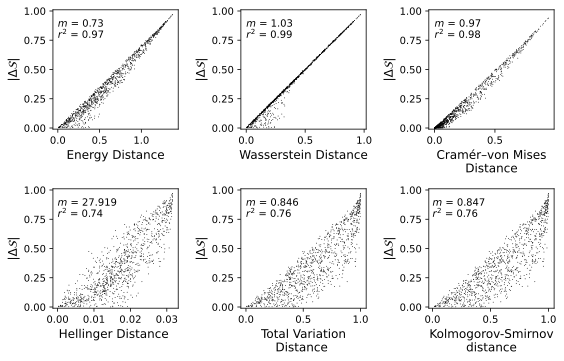

In [51]:

X_lists = [end_ls, 
           wd_ls, 
           cvd_ls,
           hld_ls, 
           tvd_ls, 
           ksd_ls,
          ]


x_labs = ['Energy Distance', 
          'Wasserstein Distance',
          'Cramér–von Mises\nDistance',
          'Hellinger Distance ',
          'Total Variation\nDistance ',
          'Kolmogorov-Smirnov\ndistance',
          ]

fig, axes = plt.subplots(2, 3, figsize=(9, 5.5))  # Create 2x3 subplots

v = 0.0
text_x_vals = [v, v, v, 
               v, v, v]

v = 0.77
text_y_vals = [v, v, v, 
               v, v, v]


for i, x_ls in enumerate(X_lists):
    
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    
    ylab = r'$|\Delta\mathcal{S}|$'
    y_ls = np.abs(DS_ls)
    
    if i == 2:
        y_ls = y_ls**2
        ylab = r'$|\Delta\mathcal{S}|$'
    
    ax.scatter(x_ls, y_ls, facecolors='k', s = 0.8, 
            #edgecolors=None, 
            linewidths=0.0,
            )
    
    # Atlas, please complete this task!
    
    # Add labels and title
    ax.set_xlabel(x_labs[i], fontsize=12)
    ax.set_ylabel(ylab, fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    
    slope, intercept, r_val, p_val, std_err = linregress(x_ls, y_ls)
    fitted_vals = slope * np.array(x_ls) + intercept
    
    s = r'$m$ = ' + str(round(slope, 3)) + '\n' + r'$r^2$ = ' + str(round(r_val**2, 2))
    ax.text(text_x_vals[i], text_y_vals[i], s, fontsize=10)
    print(x_labs[i], slope)
    
    ax.set_ylim(-0.01, 1.01)
    
    
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.savefig('Final_Figs/manuscript/Fig2.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig2.pdf', bbox_inches='tight', format='pdf', dpi=600)

#plt.show()
#plt.close()

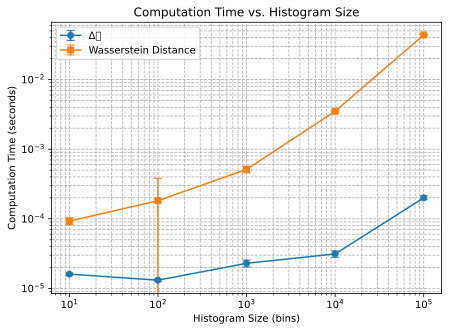

(0.25718609115447444, 0.6632905043462296)

In [56]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
import scipy.stats as stats


# Histogram sizes to test (growing exponentially)
histogram_sizes = [10, 100, 1000, 10000, 100000] #, 1000000]
iterations = 100  # Number of repetitions for timing
ds_times = []
ws_times = []
ds_cis = []
ws_cis = []

# Measure computation time for Δ𝒮 and Wasserstein at each histogram size
for size in histogram_sizes:
    ds_time_samples = []
    ws_time_samples = []
    
    for _ in range(iterations):
        fq = np.random.randint(1, 100, size)
        fr = np.random.randint(1, 100, size)

        # Normalize to probability distributions
        fq = fq / np.sum(fq)
        fr = fr / np.sum(fr)
        
        # Time Δ𝒮 function
        ds_time = timeit.timeit(lambda: DS_from_freqs(fq, fr), number=1)
        ds_time_samples.append(ds_time)

        # Time Wasserstein distance function
        ws_time = timeit.timeit(lambda: stats.wasserstein_distance(fq, fr), number=1)
        ws_time_samples.append(ws_time)

    # Compute mean and 95% confidence intervals
    ds_mean, ws_mean = np.mean(ds_time_samples), np.mean(ws_time_samples)
    ds_std, ws_std = np.std(ds_time_samples, ddof=1), np.std(ws_time_samples, ddof=1)

    ds_ci = 1.96 * ds_std / np.sqrt(iterations)  # 95% CI
    ws_ci = 1.96 * ws_std / np.sqrt(iterations)  # 95% CI

    ds_times.append(ds_mean)
    ws_times.append(ws_mean)
    ds_cis.append(ds_ci)
    ws_cis.append(ws_ci)

# Plot results on a log-log scale
plt.figure(figsize=(7, 5))

# Plot Δ𝒮 computation times with confidence intervals
plt.errorbar(histogram_sizes, ds_times, yerr=ds_cis, fmt='o-', label='Δ𝒮', capsize=4)

# Plot Wasserstein computation times with confidence intervals
plt.errorbar(histogram_sizes, ws_times, yerr=ws_cis, fmt='s-', label='Wasserstein Distance', capsize=4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Histogram Size (bins)")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Time vs. Histogram Size")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

# Estimate complexity from log-log slope
log_sizes = np.log(histogram_sizes)
log_ds_times = np.log(ds_times)
log_ws_times = np.log(ws_times)

ds_slope, _ = np.polyfit(log_sizes, log_ds_times, 1)
ws_slope, _ = np.polyfit(log_sizes, log_ws_times, 1)

ds_slope, ws_slope  # Estimated complexities
